In [1]:
import os, sys
sys.path.append('..')

import torch
import numpy as np
import numpy.random as npr
import hydra
import dill

import plotly.io as pio
pio.renderers.default = 'jupyterlab'
from scipy.interpolate import griddata
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from irrep_actions.gym_util.multistep_wrapper import MultiStepWrapper
from irrep_actions.env.pusht.pusht_keypoints_env import PushTKeypointsEnv
from irrep_actions.workflow.base_workflow import BaseWorkflow
from irrep_actions.utils import mcmc

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#checkpoint = '../data/outputs/2024.01.29/04.36.26_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/epoch=0350-test_mean_score=0.979.ckpt'
checkpoint = '../data/outputs/2024.01.29/21.56.32_train_so2_harmonic_implicit_policy_pusht_lowdim/checkpoints/latest.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
device = torch.device('cuda:0')

In [3]:
cfg = payload['config']
cls = hydra.utils.get_class(cfg._target_)

workflow = cls(cfg)
workflow: BaseWorkflow
workflow.load_payload(payload, exclude_keys=None, include_keys=None)

policy = workflow.model
policy = policy.to(device)
policy.eval()

ImplicitPolicy(
  (normalizer): LinearNormalizer(
    (params_dict): ParameterDict(
        (obs): Object of type: ParameterDict
        (action): Object of type: ParameterDict
      (obs): ParameterDict(
          (offset): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
          (scale): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
          (input_stats): Object of type: ParameterDict
        (input_stats): ParameterDict(
            (max): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (mean): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (min): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
            (std): Parameter containing: [torch.cuda.FloatTensor of size 38 (cuda:0)]
        )
      )
      (action): ParameterDict(
          (offset): Parameter containing: [torch.cuda.FloatTensor of size 2 (cuda:0)]
          (scale): Parameter containing: [torch.c

In [4]:
env = MultiStepWrapper(PushTKeypointsEnv(render_action=False), n_obs_steps=2, n_action_steps=1, max_episode_steps=300)
env.seed(100001)

In [5]:
obs = env.reset()
d = False
B = 1

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


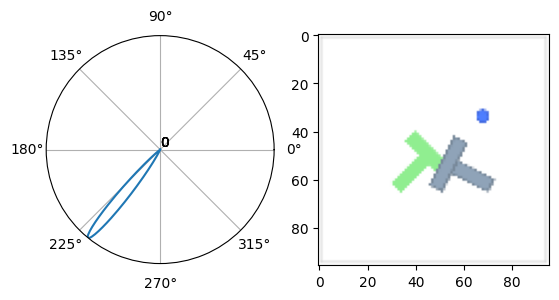

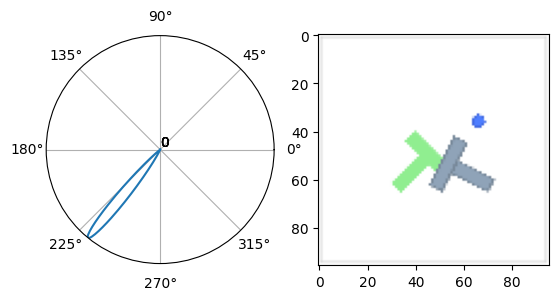

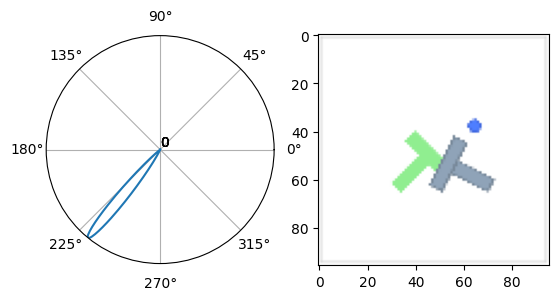

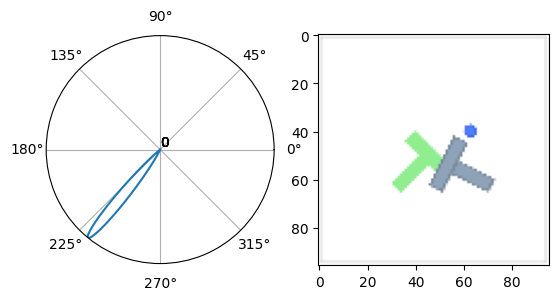

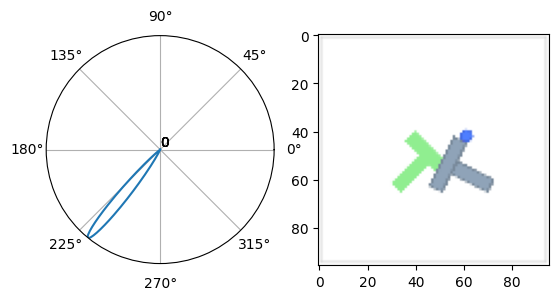

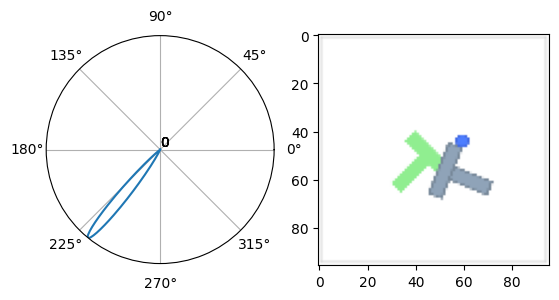

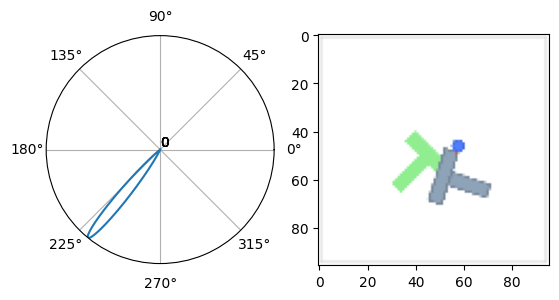

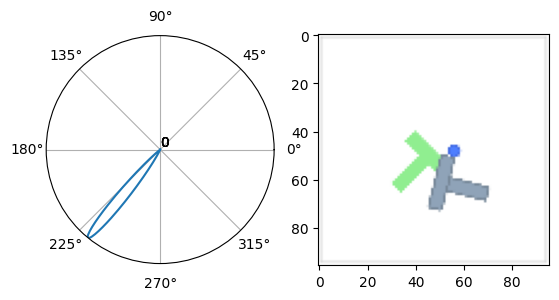

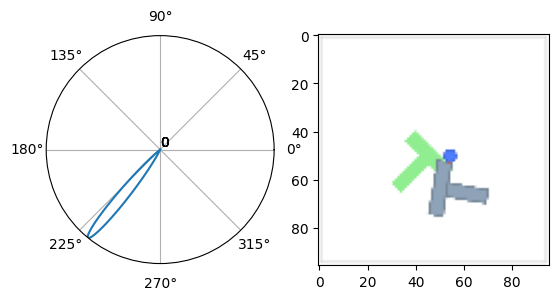

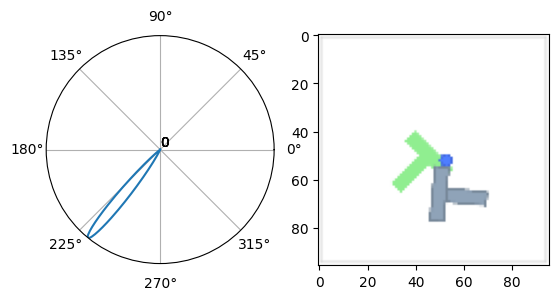

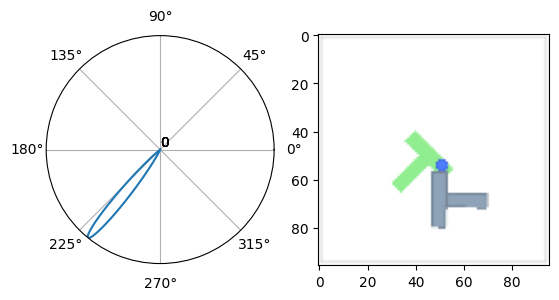

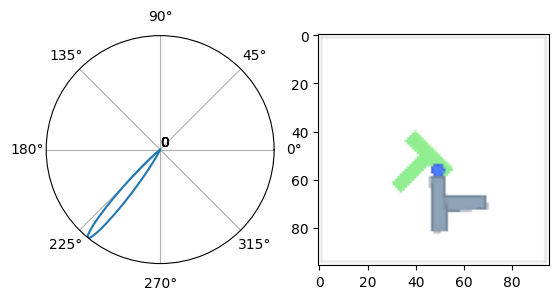

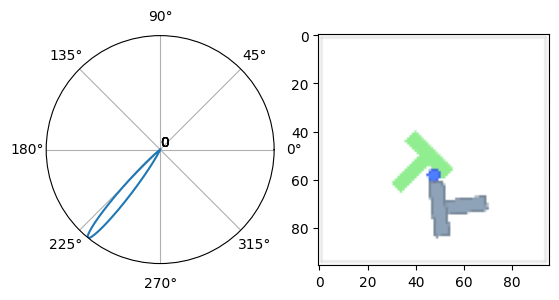

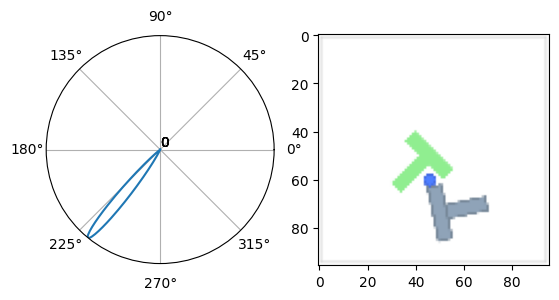

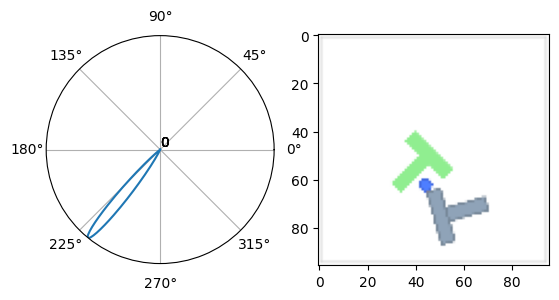

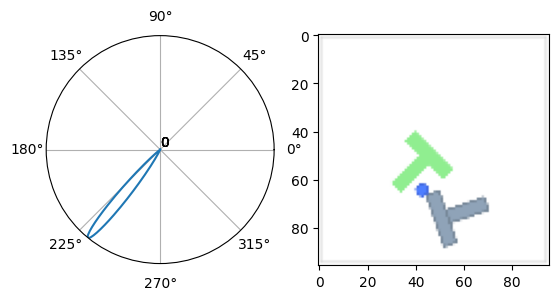

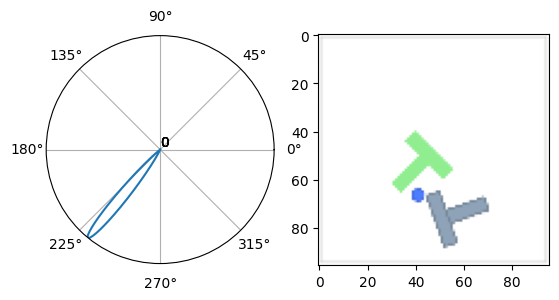

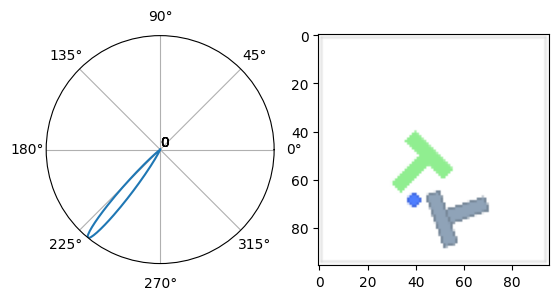

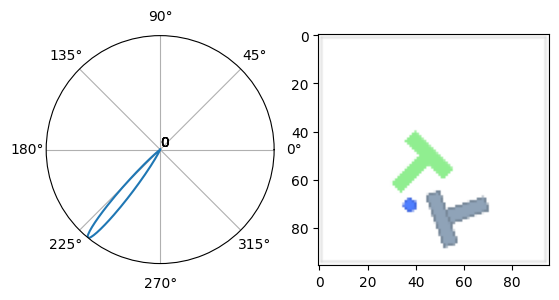

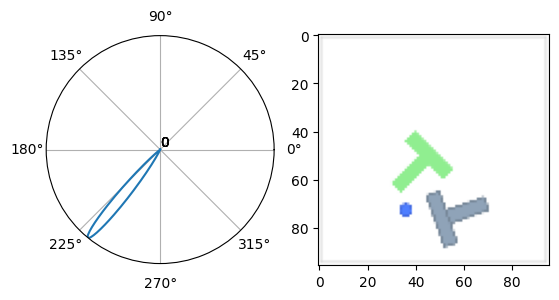

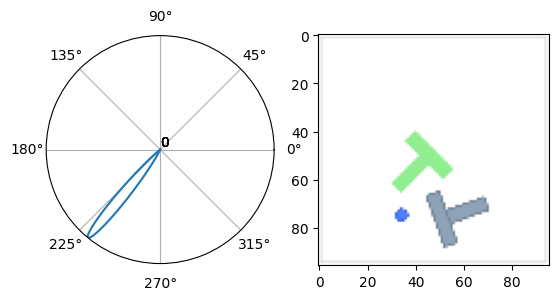

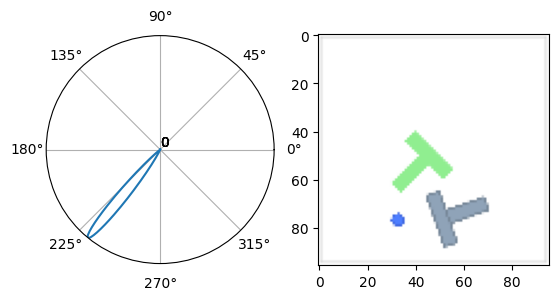

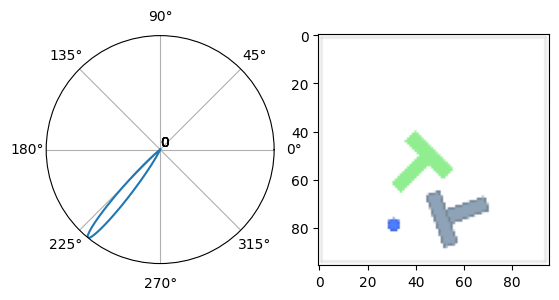

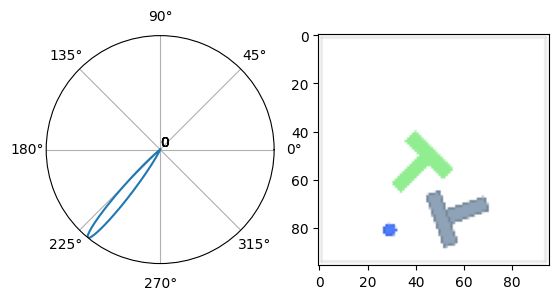

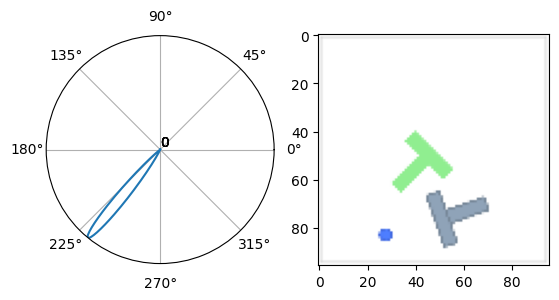

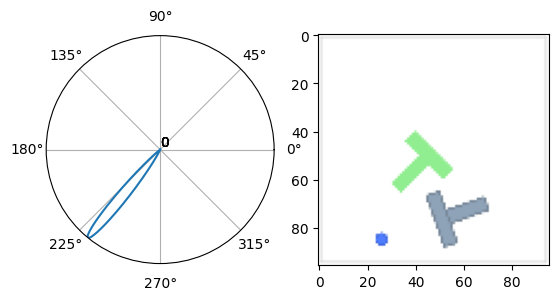

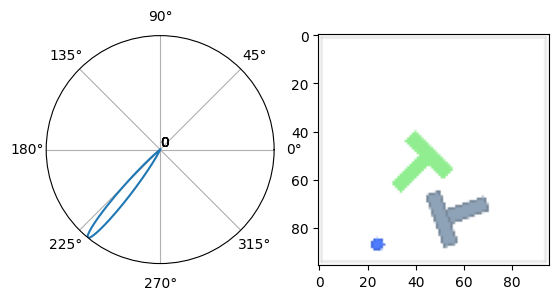

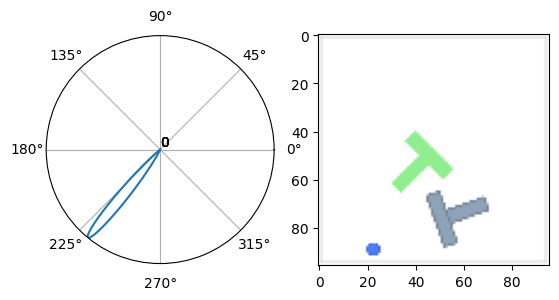

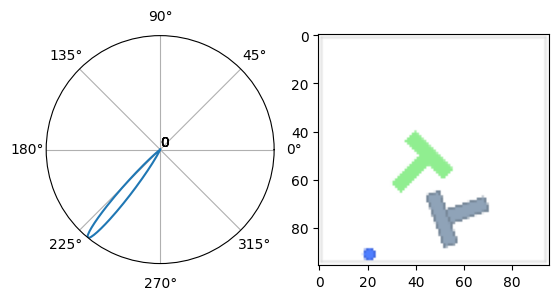

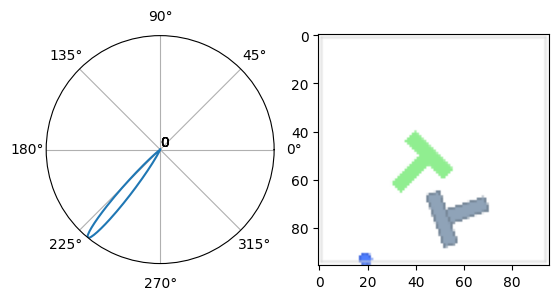

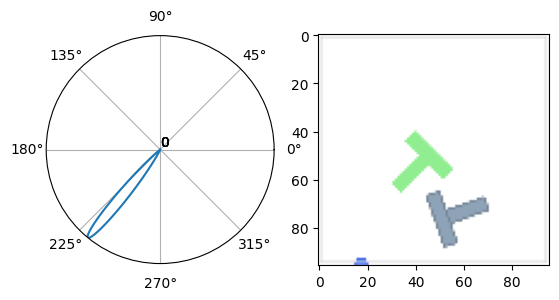

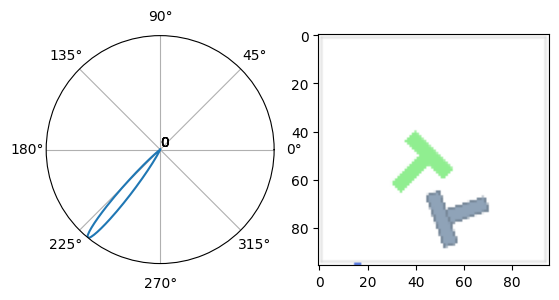

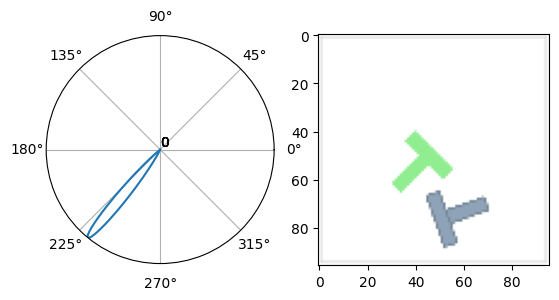

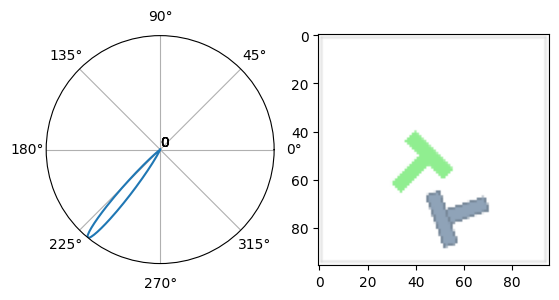

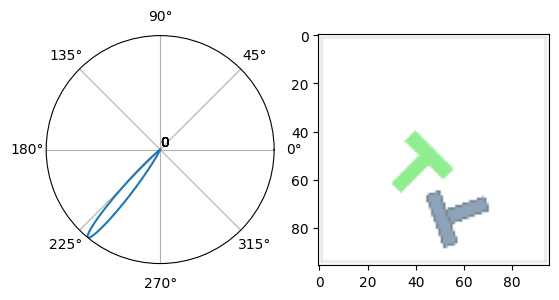

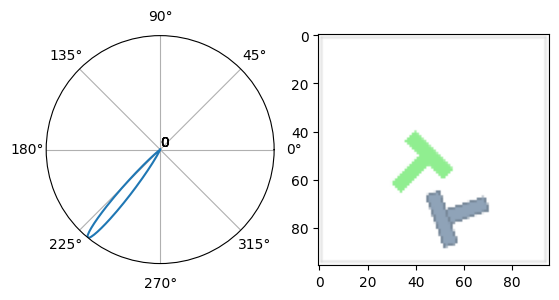

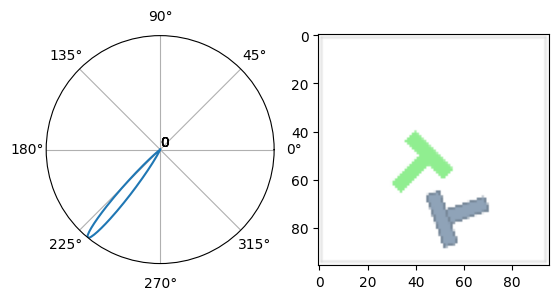

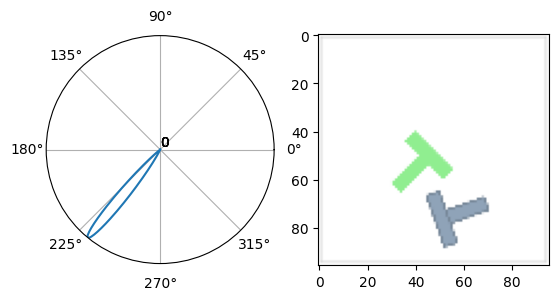

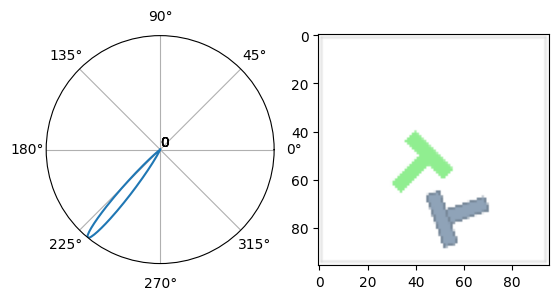

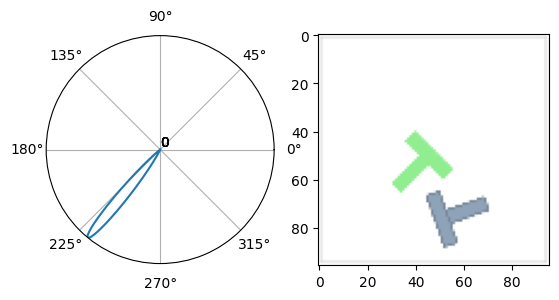

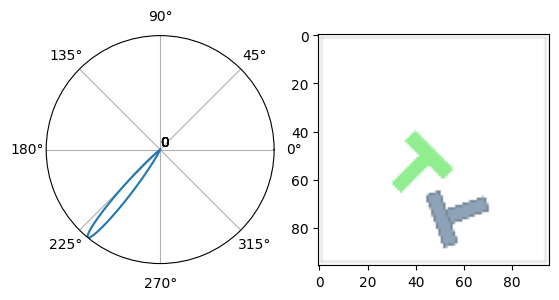

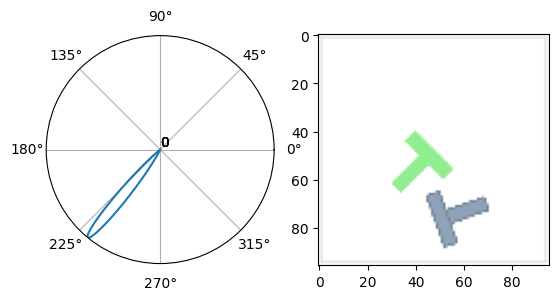

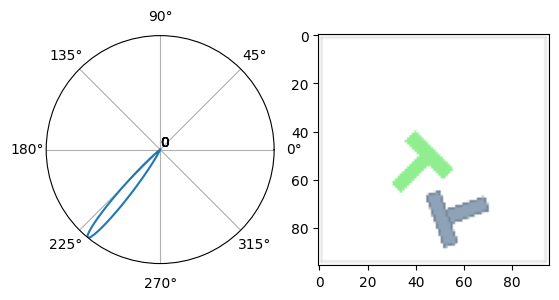

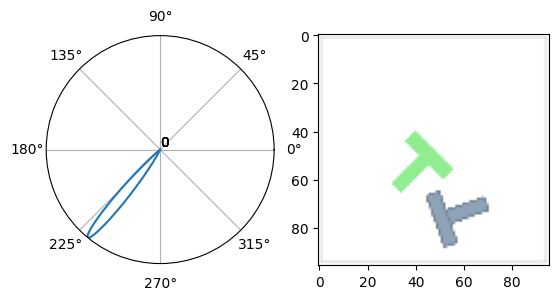

KeyboardInterrupt: 

In [6]:
while not d:
    Do = obs.shape[-1] // 2 
    obs = torch.from_numpy(obs[..., :2, :Do].astype(np.float32).reshape(B,2,-1)).to(device)
    x_obs = (obs.reshape(1,38,2)[:,:,0] - 255.0)
    y_obs = (obs.reshape(1,38,2)[:,:,1] - 255.0) * -1.0
    new_d = torch.concatenate((x_obs.unsqueeze(-1), y_obs.unsqueeze(-1)), dim=-1).view(B, 2, 38)
    nobs = policy.normalizer['obs'].normalize(new_d)
    
    action_stats = policy.get_action_stats()
    action_dist = torch.distributions.Uniform(
        low=action_stats["min"], high=action_stats["max"]
    )
    actions = action_dist.sample((1, policy.pred_n_samples, 1)).to(
        dtype=nobs.dtype
    )
    if True:
        num_disp = 10*10
        num_rot = 360*4
        mag = torch.linspace(-1, 1, num_disp)
        mag = mag.view(1, -1, 1).repeat(B, 1, num_rot).view(B, -1, 1, 1).to(device)
        theta = torch.linspace(0, 2*np.pi, num_rot)
        theta = theta.view(1, 1, -1).repeat(B, num_disp, 1).view(-1, 1).to(device)
        actions = torch.concatenate((mag, theta.view(B, -1, 1, 1)), dim=-1)

        with torch.no_grad():
            logits = policy.energy_model(nobs, mag, theta)
        action_probs = torch.softmax(logits, dim=-1)
    else:
        action_probs, actions = mcmc.iterative_dfo(
            policy.energy_model,
            nobs,
            actions,
            [action_stats['min'], action_stats['max']],
            harmonic_actions=policy.harmonic_actions,
            normalizer=policy.normalizer
        )
    
    idxs = torch.argmax(action_probs, dim=-1).unsqueeze(-1)
    actions = actions[torch.arange(B).unsqueeze(-1), idxs].squeeze(1)
    if True:
        action_probs = action_probs.view(B, num_disp, num_rot)
        max_disp = torch.max(action_probs, dim=-1)[0]
        #print(torch.argmax(max_disp, dim=1).item())
        E = action_probs[0,torch.argmax(max_disp, dim=1).item()].cpu().numpy()
  
    mag = policy.normalizer["action"].unnormalize(actions)[:,:,0]
    #theta = policy.normalizer["action"].unnormalize(actions)[:,:,1]
    theta = actions[:,:,1]
    x = mag * torch.cos(theta)
    y = mag * torch.sin(theta)
    actions = torch.concat([x.view(B,1), y.view(B,1)], dim=1).unsqueeze(1)
    
    if True:
        img = env.render('human')
        
        f = plt.figure(figsize=(10,3))
        ax1 = f.add_subplot(111)
        ax2 = f.add_subplot(131, projection='polar')
        ax1.imshow(img)
        ax2.plot(np.linspace(0, 2*np.pi, E.shape[0]), E)
        ax2.set_rmax(np.max(E))
        ax2.set_rticks(np.round(np.linspace(np.min(E), np.max(E), 5), 3))
        ax2.grid(True)
        
        #ax2.set_title("Energy", va="bottom")
        plt.show()

    x_act = actions[:,:,0]
    y_act = actions[:,:,1] * -1.0
    new_act = torch.concatenate((x_act, y_act), dim=-1).view(B,1,2)
    obs, r, d, _ = env.step(new_act.squeeze(0).cpu().numpy())